In [ ]:
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import TimeSeriesSplit

c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [ ]:
# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from src.io_data_model import (
    load_model,
    load_and_dateindex_data,
    save_model,
)

from src.transformation import (
    clean_delivery_data,
    resample_data,
    smooth_series,
)

from src.anomaly import (
    detect_anomalies,
    calculate_anomaly_percentage,
)

from src.plotting import (
    plot_anomalies,
    plot_anomalies_and_rolling,
    plot_forecast,
    plot_train_splits,
    plot_test_splits,
    plot_eighty_twenty_series,
)

from src.time_series import (
    find_best_arima_order,
    find_best_sarima_model,
    evaluate_models,
    rank_models,
    fit_sarima_model,
    fit_exp_smooth_model,
    fit_prophet_model,
    display_metrics,
)

In [3]:
from yellow_maize_delivery_parms import config

CROP = config["CROP"]
DATA_FILE = config["DATA_FILE"]
DATA_FILE_PATH = config["DATA_FILE_PATH"]
MODEL_FILE = config["MODEL_FILE"]
MODEL_PARMS = config["MODEL_PARMS"]
MODEL_PATH = config["MODEL_PATH"]
PERIOD = config["PERIOD"]
ROLLING_AVERAGE_WINDOW = config["ROLLING_AVERAGE_WINDOW"]
SMOOTHED_TARGET_VARIABLE = config["SMOOTHED_TARGET_VARIABLE"]
TARGET_VARIABLE = config["TARGET_VARIABLE"]
TRAIN_SPLIT = config["TRAIN_SPLIT"]

The overall code in this Jupyter Notebook is designed to analyze and forecast crop deliveries using various time series models. The workflow includes data loading, preprocessing, exploratory data analysis, model fitting, evaluation, and forecasting. The models used include SARIMA, Exponential Smoothing, and Prophet. The notebook also includes visualizations to help understand the data and the model outputs.

In [4]:
# loaded_model = load_model(MODEL_PATH, MODEL_FILE)
# print(loaded_model.summary())

In [4]:
indexed_df = load_and_dateindex_data(DATA_FILE_PATH, DATA_FILE)
cleaned_df = clean_delivery_data(indexed_df, TARGET_VARIABLE, CROP)
cleaned_df.head()

,Crop Delivery (Tonnes)
Date,
2008-01-03,0
2008-01-10,0
2008-01-17,0
2008-01-24,0
2008-01-31,0


In [5]:
# Get summary statistics
cleaned_df.describe().map(lambda x: f"{x:,.0f}")

,Crop Delivery (Tonnes)
count,867
mean,"92,483"
std,"166,021"
min,0
25%,"3,256"
50%,"18,236"
75%,"79,283"
max,"1,099,641"


<Axes: xlabel='Date', ylabel='Crop Delivery (Tonnes)'>

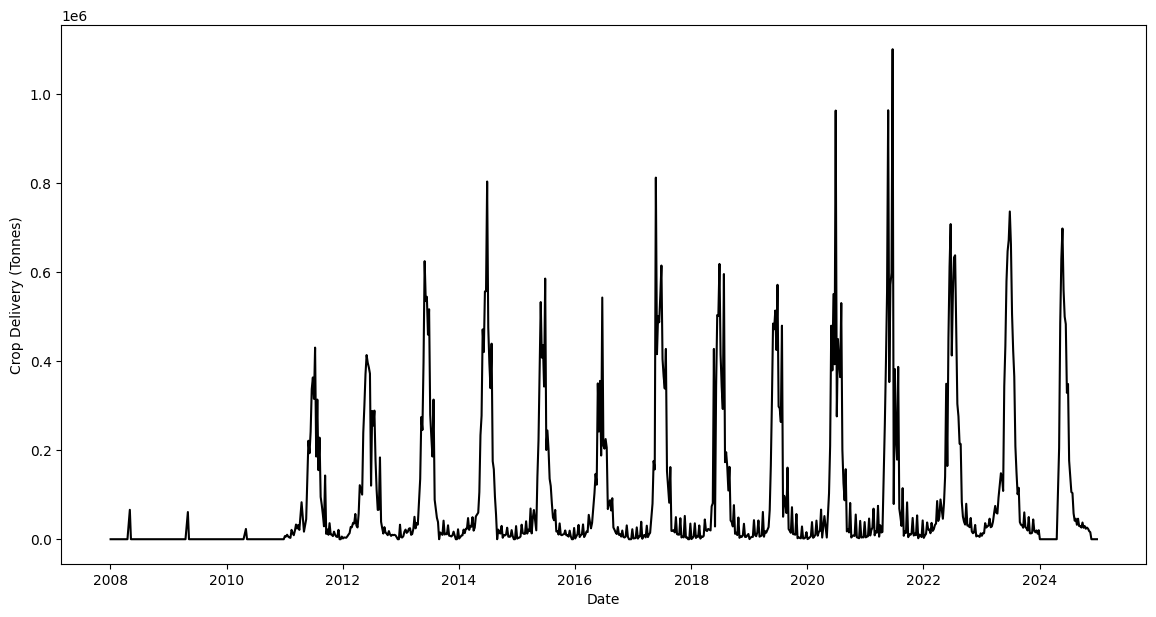

In [6]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=cleaned_df, x=cleaned_df.index, y=TARGET_VARIABLE, color="black")

In [7]:
outlier_df, anomalies = detect_anomalies(cleaned_df, TARGET_VARIABLE, 0.05)
anomaly_df = calculate_anomaly_percentage(outlier_df)
anomaly_df

,Anomaly,Percentage
0,Not Anomaly,94.925029
1,Anomaly,5.074971


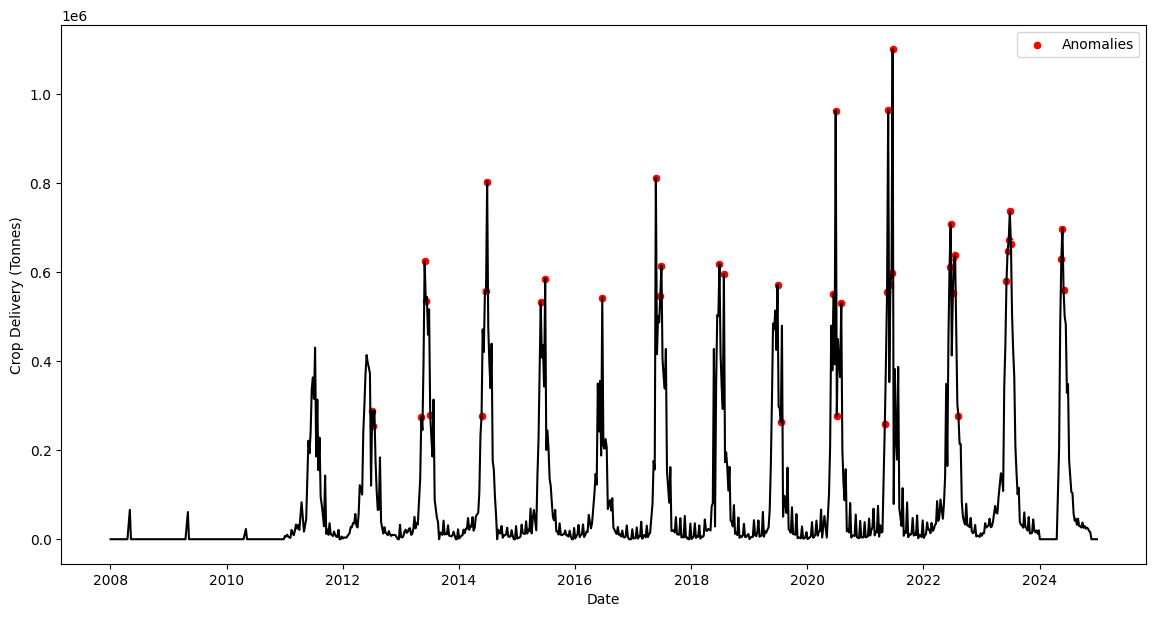

In [8]:
plot_anomalies(outlier_df, anomalies, TARGET_VARIABLE)

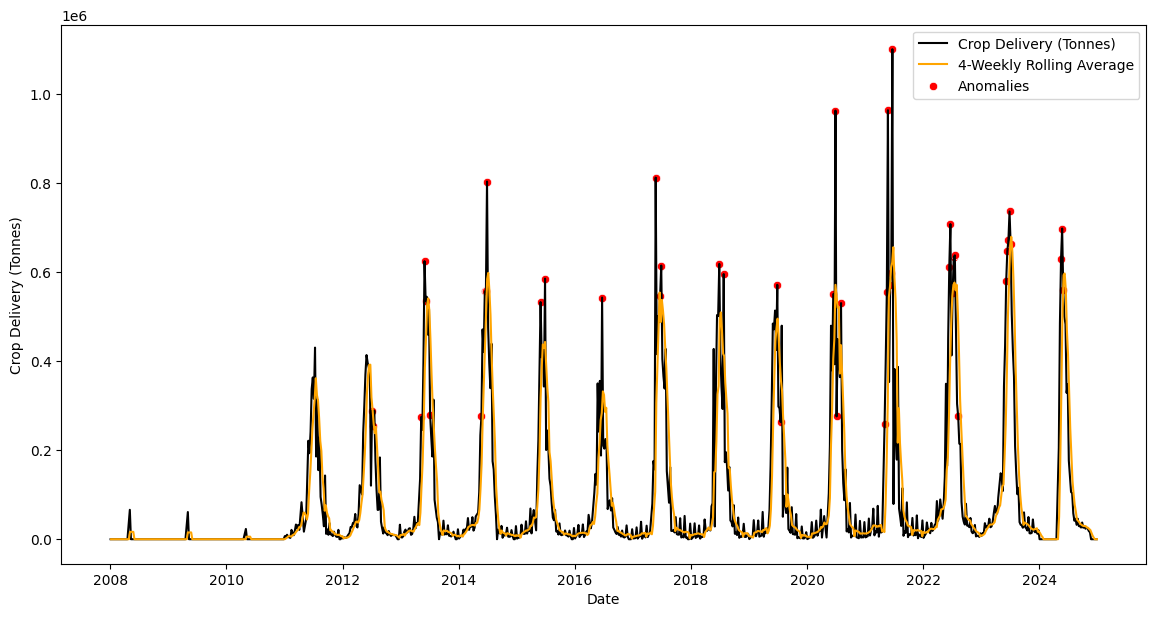

In [9]:
resampled_df = resample_data(outlier_df, TARGET_VARIABLE)
smoothed_series = smooth_series(
    resampled_df, TARGET_VARIABLE, ROLLING_AVERAGE_WINDOW, SMOOTHED_TARGET_VARIABLE
)

# Call the function
plot_anomalies_and_rolling(
    outlier_df, smoothed_series, anomalies, TARGET_VARIABLE, SMOOTHED_TARGET_VARIABLE
)

14:11:20 - cmdstanpy - INFO - Chain [1] start processing
14:11:20 - cmdstanpy - INFO - Chain [1] done processing


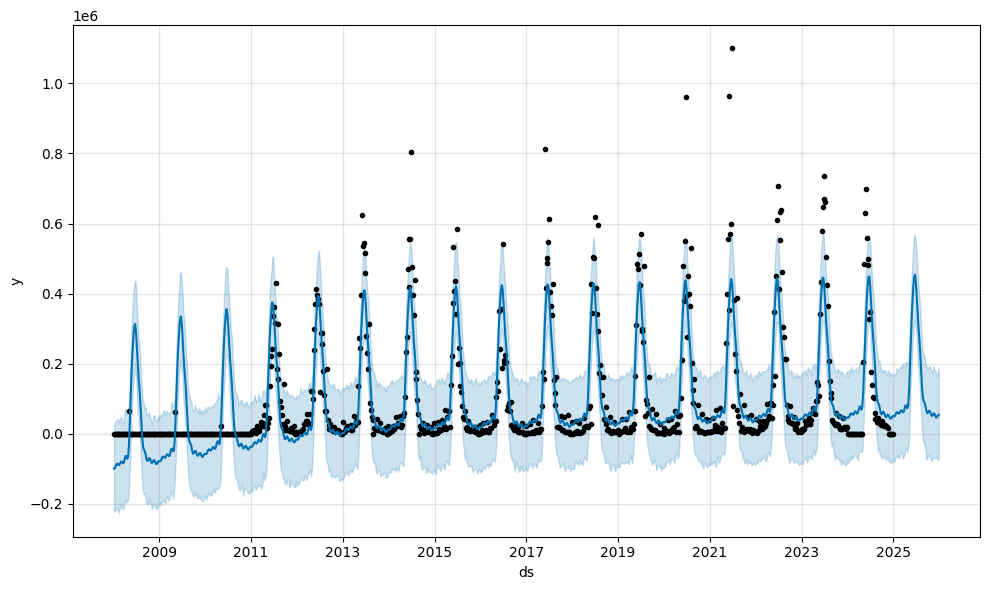

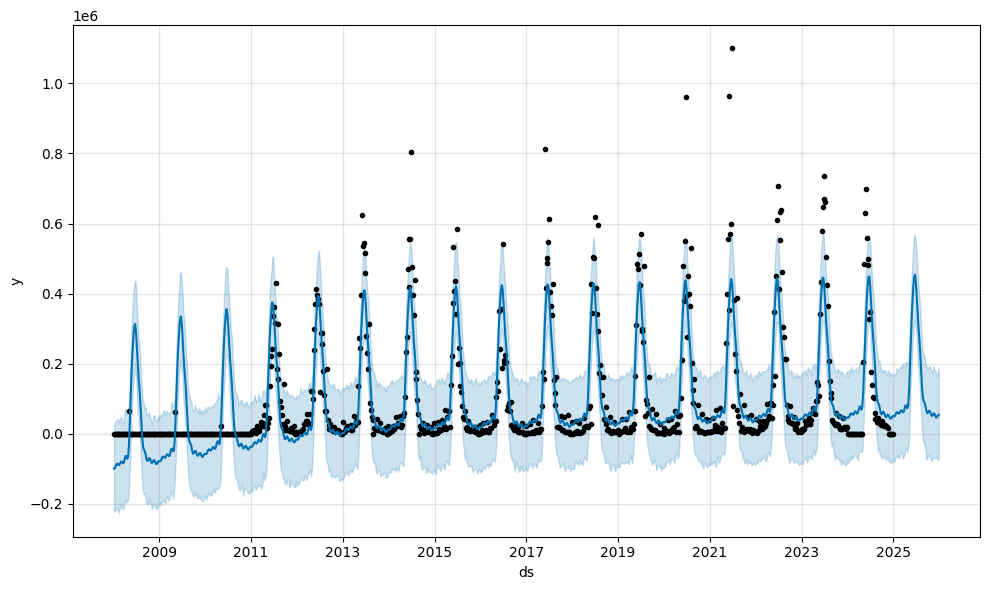

In [10]:
# Create a Prophet model with the default parameters
model = Prophet()
# Fit the model to the data
fb_df = resampled_df.reset_index().rename(columns={"Date": "ds", TARGET_VARIABLE: "y"})
model.fit(fb_df)

# Forecast for the next 52 weeks (for example)
future = model.make_future_dataframe(periods=PERIOD, freq="W")  # weekly forecast
forecast = model.predict(future)
model.plot(forecast)

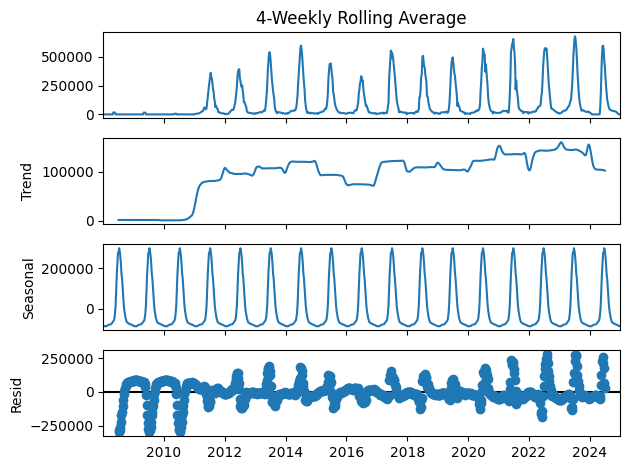

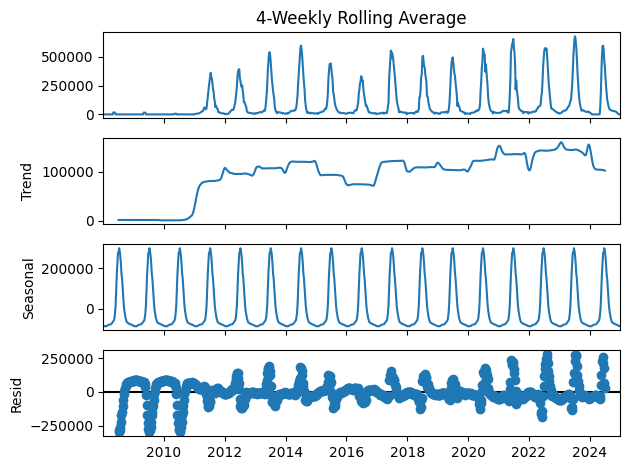

In [11]:
# Decompose the time series using the additive method
decomposition = seasonal_decompose(x=smoothed_series, model="additive", period=PERIOD)
# View the decomposed components
decomposition.plot()

In [12]:
# Perform the ADF test on the time series
result = adfuller(smoothed_series)

# Print the ADF test statistic, the p-value, and the critical values
print("ADF test statistic:", result[0])
print("p-value:", result[1])
print("Critical values:")
for key, value in result[4].items():
    print(key, value)

ADF test statistic: -7.578533818784852
p-value: 2.7206024090252243e-11
Critical values:
1% -3.4379324415517494
5% -2.864887107873992
10% -2.568552251328143


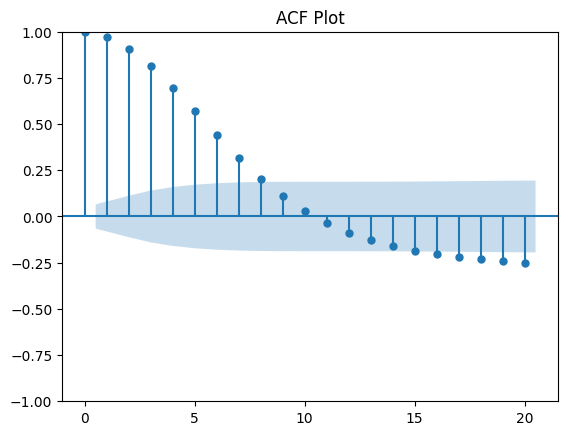

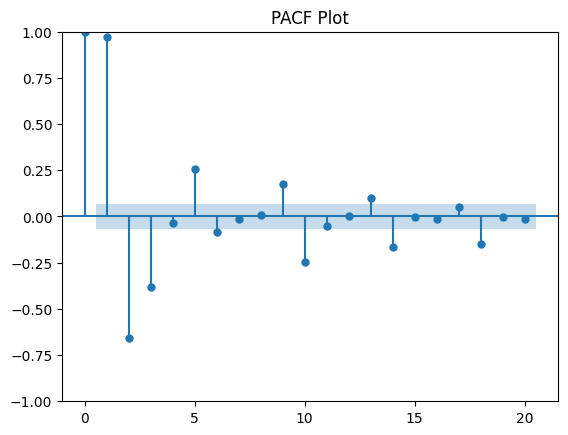

In [13]:
# Generate ACF and PACF plots
plot_acf(smoothed_series, lags=20)
plt.title("ACF Plot")
plt.show()

plot_pacf(smoothed_series, lags=20)
plt.title("PACF Plot")
plt.show()

In [14]:
best_order, best_aic = find_best_arima_order(smoothed_series)
print(f"Best model order: {best_order} with AIC: {best_aic}")

c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Best model order: (2, 0, 2) with AIC: 20413.114932234752


In [15]:
# Build an ARIMA(1, 0, 1) model for the time series
model = ARIMA(smoothed_series, order=(2, 0, 2))
# Fit the model to the data
model_fit = model.fit()
# View the summary of the model
print(model_fit.summary())

                                  SARIMAX Results                                   
Dep. Variable:     4-Weekly Rolling Average   No. Observations:                  887
Model:                       ARIMA(2, 0, 2)   Log Likelihood              -10200.557
Date:                      Thu, 12 Dec 2024   AIC                          20413.115
Time:                              14:11:30   BIC                          20441.842
Sample:                          01-06-2008   HQIC                         20424.097
                               - 12-29-2024                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        9.12e+04   2.54e+04      3.588      0.000    4.14e+04    1.41e+05
ar.L1          1.6605      0.018     93.478      0.000       1.626       1.695
ar.L

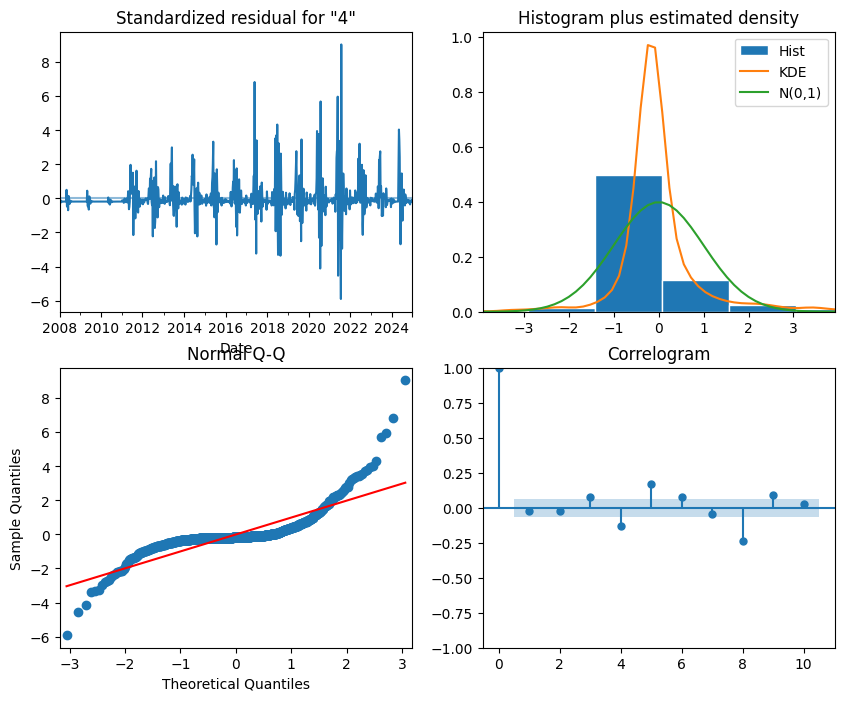

In [16]:
# Plot the diagnostic charts for the model
model_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

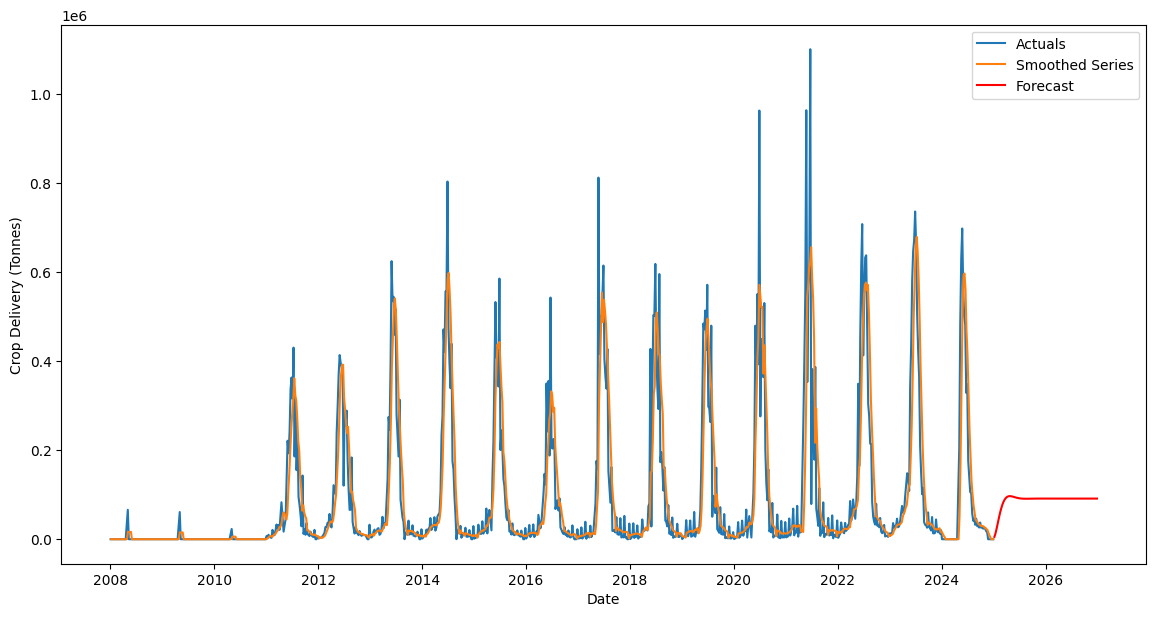

In [17]:
# Forecasting crop deliveries for the next year
num_years = 2
forecast = model_fit.forecast(steps=PERIOD * num_years)

# Call the function
plot_forecast(
    forecast,
    smoothed_series,
    cleaned_df,
    TARGET_VARIABLE,
    SMOOTHED_TARGET_VARIABLE,
    PERIOD,
    num_years,
)

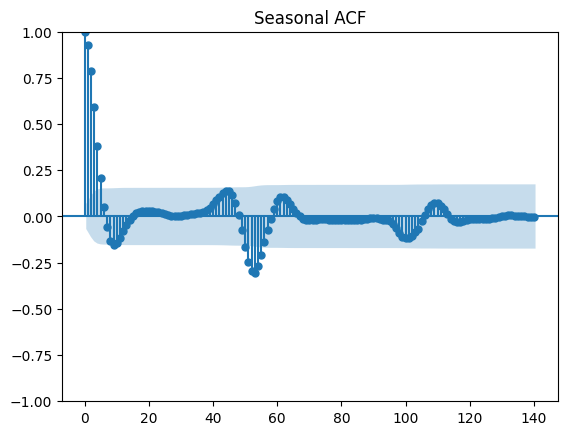

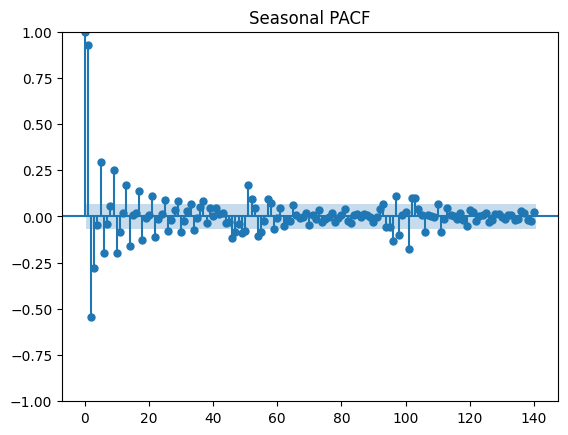

In [18]:
# Seasonal differencing (if necessary)
seasonal_diff = smoothed_series.diff(PERIOD).dropna()

# ACF and PACF for seasonally differenced data
plot_acf(seasonal_diff, lags=140)
plt.title("Seasonal ACF")
plt.show()

plot_pacf(seasonal_diff, lags=140)
plt.title("Seasonal PACF")
plt.show()

In [19]:
# best_order, best_seasonal_order = find_best_sarima_model(
#     resampled_df[TARGET_VARIABLE], PERIOD
# )
# print(f"Best order: {best_order}")
# print(f"Best seasonal order: {best_seasonal_order}")

In [30]:
# Build a seasonal ARIMA model for the time series
model = SARIMAX(
    smoothed_series,
    order=MODEL_PARMS["order"],
    seasonal_order=MODEL_PARMS["seasonal_order"],
)
# Fit the model to the data
model_fit = model.fit()
# View the summary of the model
print(model_fit.summary())

: 

: 

In [ ]:
# Plot the diagnostic charts for the model
model_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

In [ ]:
# Forecasting crop deliveries for the next year
num_years = 2
forecast = model_fit.forecast(steps=PERIOD * num_years)

# Call the function
plot_forecast(
    forecast,
    smoothed_series,
    cleaned_df,
    TARGET_VARIABLE,
    SMOOTHED_TARGET_VARIABLE,
    PERIOD,
    num_years,
)

In [19]:
# Apply the Holt-Winters seasonal method with additive trend and seasonality to the time series
model = ExponentialSmoothing(
    smoothed_series, trend="add", seasonal="add", seasonal_periods=PERIOD
)
# Fit the model to the data
model_fit = model.fit()
# View the summary of the model
print(model_fit.summary())

                         ExponentialSmoothing Model Results                         
Dep. Variable:     4-Weekly Rolling Average   No. Observations:                  887
Model:                 ExponentialSmoothing   SSE                   739101369833.021
Optimized:                             True   AIC                          18331.739
Trend:                             Additive   BIC                          18599.859
Seasonal:                          Additive   AICC                         18340.005
Seasonal Periods:                        52   Date:                 Thu, 12 Dec 2024
Box-Cox:                              False   Time:                         12:14:44
Box-Cox Coeff.:                        None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8535714                alpha           

c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


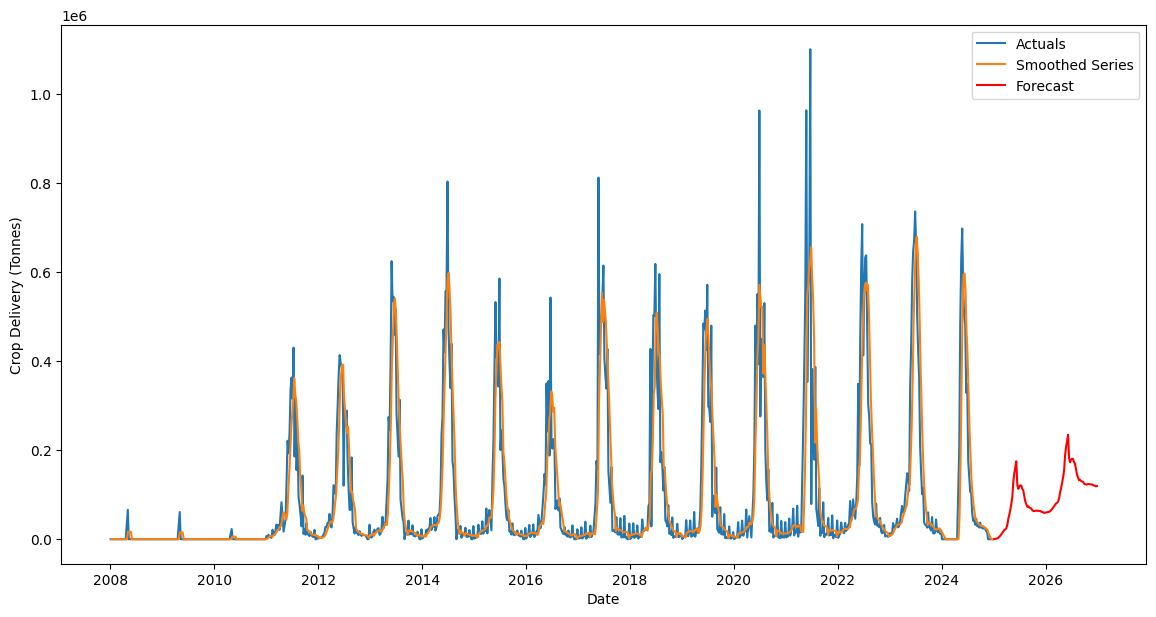

In [20]:
# Forecasting crop deliveries for the next year
num_years = 2
forecast = model_fit.forecast(steps=PERIOD * num_years)
forecast.rename("predicted_mean", inplace=True)

# Call the function
plot_forecast(
    forecast,
    smoothed_series,
    cleaned_df,
    TARGET_VARIABLE,
    SMOOTHED_TARGET_VARIABLE,
    PERIOD,
    num_years,
)

12:14:47 - cmdstanpy - INFO - Chain [1] start processing
12:14:47 - cmdstanpy - INFO - Chain [1] done processing


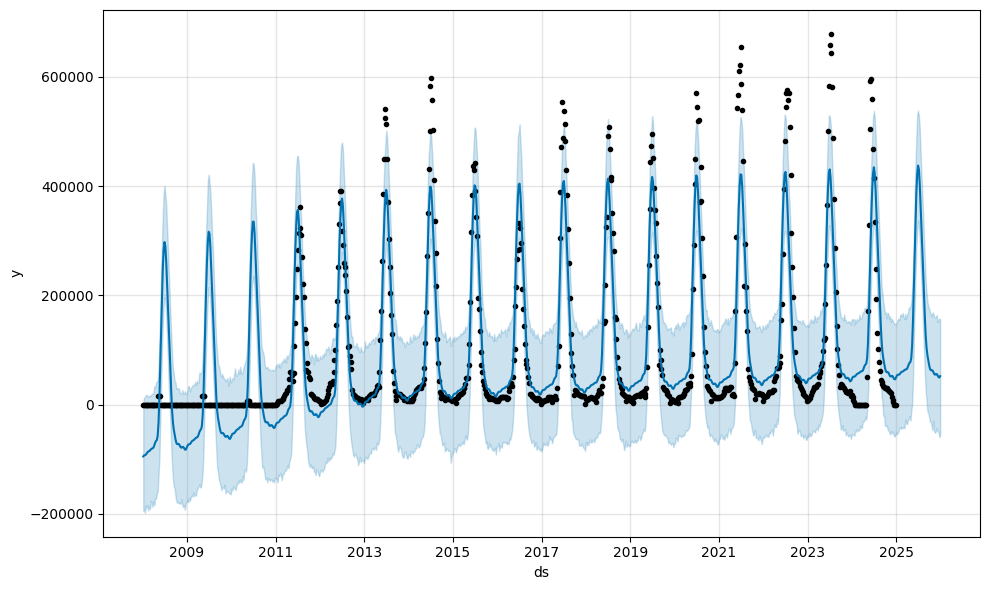

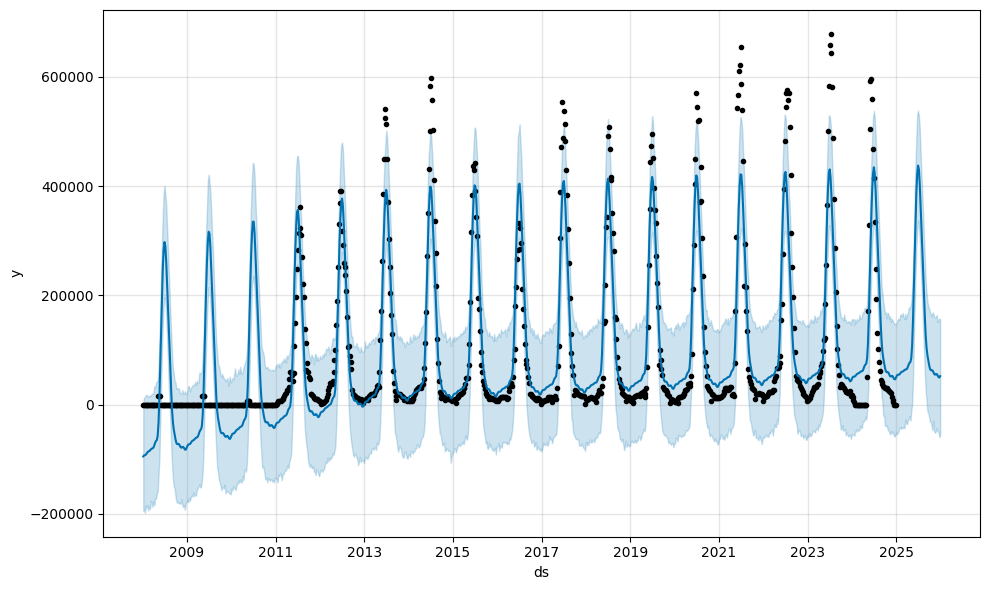

In [21]:
# Create a Prophet model with the default parameters
model = Prophet()
# Fit the model to the data
fb_df = smoothed_series.reset_index().rename(
    columns={"Date": "ds", SMOOTHED_TARGET_VARIABLE: "y"}
)
model.fit(fb_df)

# Forecast for the next 52 weeks (for example)
future = model.make_future_dataframe(periods=PERIOD, freq="W")  # weekly forecast
forecast = model.predict(future)
model.plot(forecast)

Train Split 1: 2008-01-06 to 2010-11-28 (152 samples)
Train Split 2: 2008-01-06 to 2013-09-22 (299 samples)
Train Split 3: 2008-01-06 to 2016-07-17 (446 samples)
Train Split 4: 2008-01-06 to 2019-05-12 (593 samples)
Train Split 5: 2008-01-06 to 2022-03-06 (740 samples)


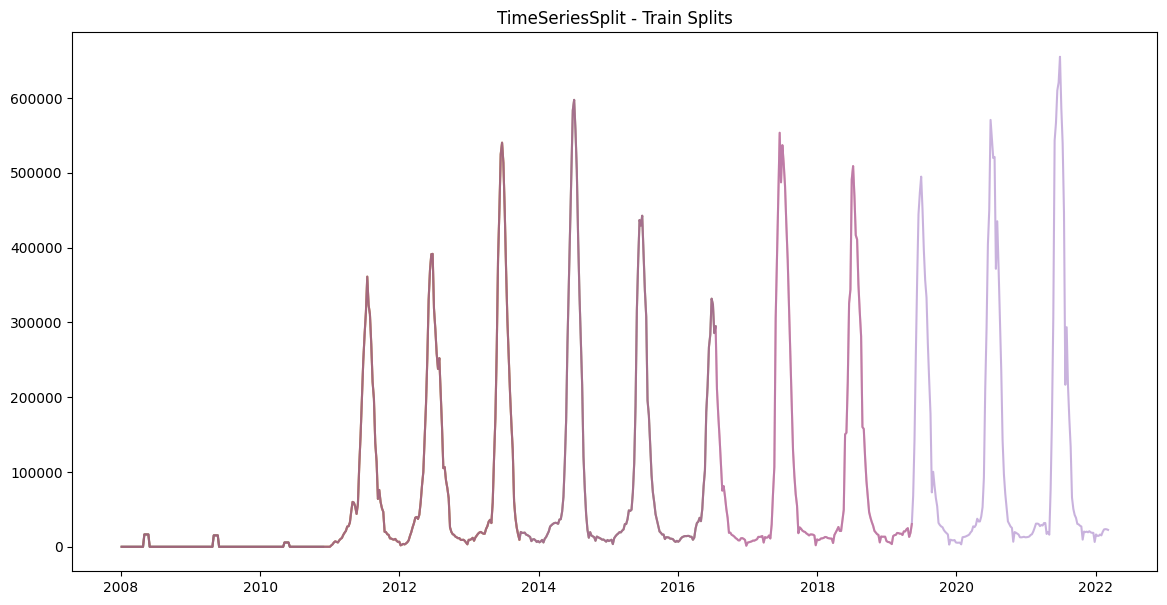

In [20]:
# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit()
plot_train_splits(tscv, smoothed_series)

Test Split 1: 2010-12-05 to 2013-09-22 (147 samples)
Test Split 2: 2013-09-29 to 2016-07-17 (147 samples)
Test Split 3: 2016-07-24 to 2019-05-12 (147 samples)
Test Split 4: 2019-05-19 to 2022-03-06 (147 samples)
Test Split 5: 2022-03-13 to 2024-12-29 (147 samples)


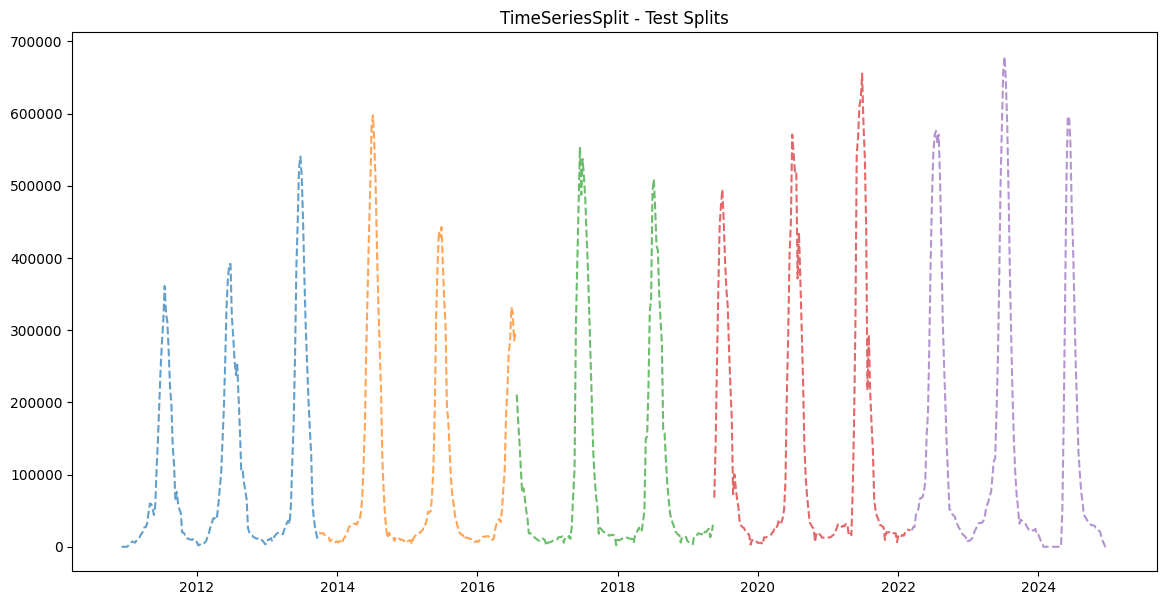

In [21]:
plot_test_splits(tscv, smoothed_series)

In [ ]:
tscv = TimeSeriesSplit(n_splits=2)  # Create 4 splits
results = evaluate_models(smoothed_series, tscv, PERIOD, MODEL_PARMS)
results

In [ ]:
ranked_results_df = rank_models(results)

In [22]:
# Assuming 'train' is your training data and 'test' is your test data
eighty_percent = int(TRAIN_SPLIT * len(smoothed_series))
train = smoothed_series[:eighty_percent]  # Example: first 80% for training
test = smoothed_series[eighty_percent:]  # Remaining 20% for testing

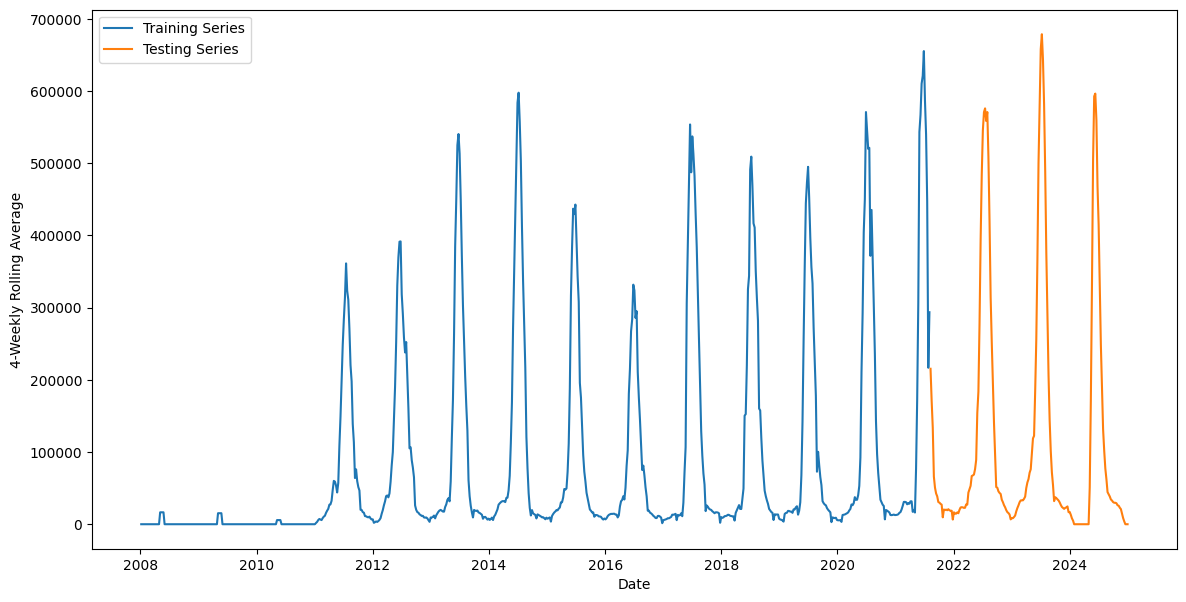

In [23]:
plot_eighty_twenty_series(train, test)

In [24]:
# Call the function
sarima, sarima_forecast, mae_sarima, rmse_sarima = fit_sarima_model(
    train, test, MODEL_PARMS
)

SARIMA - MAE: 55850.24112974088, RMSE: 85391.41495629394, MAPE: inf


In [25]:
# Call the function
exp_smooth, exp_smooth_forecast, mae_exp_smooth, rmse_exp_smooth = fit_exp_smooth_model(
    train, test, PERIOD
)

SARIMA - MAE: 1871283.3105489602, RMSE: 2188360.4466571026, MAPE: inf


c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [26]:
model, prophet_forecast, mae_prophet, rmse_prophet = fit_prophet_model(fb_df, test)

14:15:57 - cmdstanpy - INFO - Chain [1] start processing
14:15:57 - cmdstanpy - INFO - Chain [1] done processing


SARIMA - MAE: 63207.919451279304, RMSE: 96575.40189655036, MAPE: inf


In [27]:
# Create a dictionary with the metrics
metrics = {
    "Model": ["SARIMA", "Exponential Smoothing", "Prophet"],
    "MAE": [mae_sarima, mae_exp_smooth, mae_prophet],
    "RMSE": [rmse_sarima, rmse_exp_smooth, rmse_prophet],
}

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics)

# Call the function
display_metrics(metrics_df)

,Model,MAE,RMSE,MAE Rank,RMSE Rank
0,SARIMA,5.585024e+04,8.539141e+04,1.0,1.0
2,Prophet,6.320792e+04,9.657540e+04,2.0,2.0
1,Exponential Smoothing,1.871283e+06,2.188360e+06,3.0,3.0


<Axes: xlabel='Date', ylabel='4-Weekly Rolling Average'>

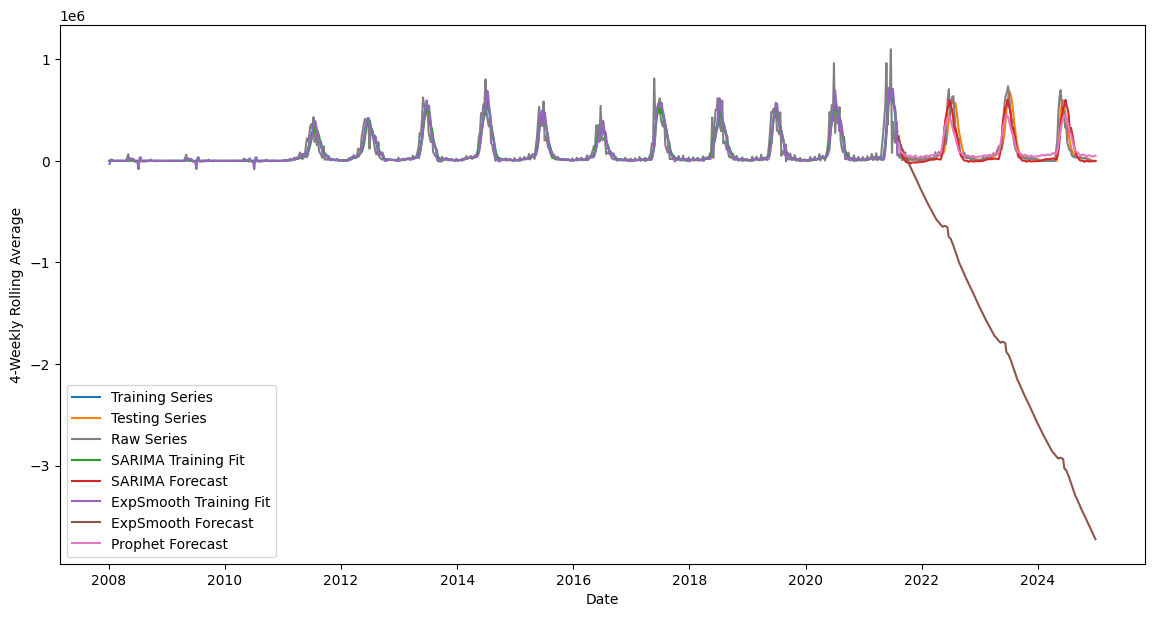

In [28]:
plt.figure(figsize=(14, 7))

# Plot the training series
sns.lineplot(x=train.index, y=train, label="Training Series")

# Plot the testing series
sns.lineplot(x=test.index, y=test, label="Testing Series")

# Plot the original series
sns.lineplot(
    x=cleaned_df.index,
    y=cleaned_df[TARGET_VARIABLE],
    label="Raw Series",
    color="gray",
    dashes=True,
)

# Plot SARIMA model output
sns.lineplot(x=train.index, y=sarima.fittedvalues, label="SARIMA Training Fit")
sns.lineplot(x=test.index, y=sarima_forecast, label="SARIMA Forecast")

# Plot Exp model output
sns.lineplot(x=train.index, y=exp_smooth.fittedvalues, label="ExpSmooth Training Fit")
sns.lineplot(x=test.index, y=exp_smooth_forecast, label="ExpSmooth Forecast")

# Plot Prophet model output
sns.lineplot(
    x=prophet_forecast.index,
    y=prophet_forecast.to_frame()["yhat"],
    label="Prophet Forecast",
)

<Axes: xlabel='Date', ylabel='4-Weekly Rolling Average'>

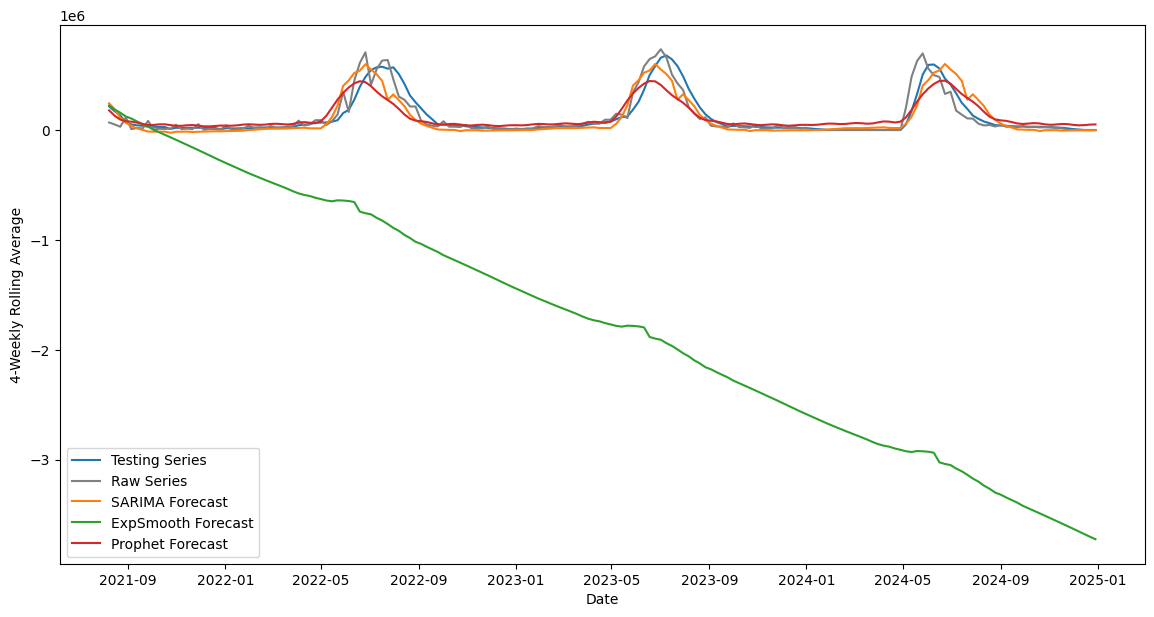

In [29]:
plt.figure(figsize=(14, 7))

# Plot the testing series
sns.lineplot(x=test.index, y=test, label="Testing Series")

# Plot the original series
sns.lineplot(
    x=resampled_df.loc[test.index].index,
    y=resampled_df.loc[test.index, TARGET_VARIABLE],
    label="Raw Series",
    color="gray",
    dashes=True,
)

# Plot SARIMA model output
sns.lineplot(x=test.index, y=sarima_forecast.loc[test.index], label="SARIMA Forecast")

# Plot Exp model output
sns.lineplot(
    x=test.index, y=exp_smooth_forecast.loc[test.index], label="ExpSmooth Forecast"
)

# Plot Prophet model output
sns.lineplot(x=test.index, y=prophet_forecast.loc[test.index], label="Prophet Forecast")

In [30]:
save_model(sarima, MODEL_PATH, MODEL_FILE)